# Required libraries

In [1]:

import numpy as np
from scipy import ndimage
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from numba import njit, prange
import networkx as nx
import rasterio
from rasterio.features import shapes
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon
import geopandas as gpd
import gc
from shapely.geometry import shape


# Script 


## Function definitions

### VO related functions

In [2]:
#VO related functions

@njit(parallel=True)
def calculate_vo(image, radius, exaggeration):
    rows, cols = image.shape
    vo_image = np.zeros_like(image, dtype=np.float32)
    circular_mask = create_circular_mask(radius)

    total_pixels = rows * cols

    for idx in prange(total_pixels):
        i, j = idx // cols, idx % cols

        volume_above_topography = 0.0
        total_sphere_volume = 0.0

        base_height = image[i, j] * exaggeration

        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                ni, nj = i + di, j + dj

                if 0 <= ni < rows and 0 <= nj < cols and circular_mask[di + radius, dj + radius]:
                    height_in_sphere = radius - np.sqrt(di**2 + dj**2)
                    height_above_base = base_height - (image[ni, nj] * exaggeration)
                    effective_height = min(height_in_sphere, height_above_base)

                    if effective_height > 0:
                        volume_above_topography += effective_height

                    total_sphere_volume += height_in_sphere

        if total_sphere_volume > 0:
            vo_image[i, j] = volume_above_topography / total_sphere_volume

    return vo_image

@njit
def create_circular_mask(radius):
    size = 2 * radius + 1
    mask = np.zeros((size, size), dtype=np.bool_)
    center = radius
    for i in range(size):
        for j in range(size):
            if (i - center) ** 2 + (j - center) ** 2 <= radius ** 2:
                mask[i, j] = True
    return mask

@njit
def threshold_vo(vo_image, threshold):
    thresholded_image = np.where(vo_image >= threshold, 1, 0)
    return thresholded_image

def fill_bedform_holes(image):
    filled_image = ndimage.binary_fill_holes(image).astype(int)
    return filled_image

### Skeleton creation and simplification related functions 

In [3]:


# SKeleton creation and simplification related functions 

def skeleton_to_graph(skeleton):
    """Convert skeleton to graph."""
    G = nx.Graph()
    rows, cols = skeleton.shape
    for row in range(rows):
        for col in range(cols):
            if skeleton[row, col]:
                G.add_node((row, col))
                # Add edges to the 8-connected neighbors
                for d_row, d_col in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                    n_row, n_col = row + d_row, col + d_col
                    if 0 <= n_row < rows and 0 <= n_col < cols and skeleton[n_row, n_col]:
                        G.add_edge((row, col), (n_row, n_col))
    return G

def find_longest_paths(G):
    """Find the longest paths in each connected component of the graph."""
    longest_paths = []
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        nodes = list(subgraph.nodes)
        longest_path = []
        for node in nodes:
            lengths = nx.single_source_dijkstra_path_length(subgraph, node)
            farthest_node = max(lengths, key=lengths.get)
            path = nx.dijkstra_path(subgraph, node, farthest_node)
            if len(path) > len(longest_path):
                longest_path = path
        longest_paths.append(longest_path)
    return longest_paths

def convert_to_geographical_coords(longest_paths, transform):
    """Convert pixel coordinates of the longest paths to geographical coordinates."""
    geographical_paths = []
    for path in longest_paths:
        geo_path = []
        for row, col in path:
            x, y = rasterio.transform.xy(transform, row, col)
            geo_path.append((x, y))
        geographical_paths.append(geo_path)
    return geographical_paths

def export_paths_to_shapefile(geographical_paths, crs, output_file):
    """Export the longest paths as a shapefile."""
    line_geometries = [LineString(path) for path in geographical_paths if len(path) > 1]
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs=crs)
    gdf.to_file(output_file, driver='ESRI Shapefile')

    
def create_longest_paths_image(skeleton, longest_paths):
    """ Create a binary image with the longest paths marked """
    paths_image = np.zeros_like(skeleton)
    for longest_path in longest_paths:
        for (row, col) in longest_path:
            paths_image[row, col] = 1
    return paths_image



### Functions related to converting to shapefiles 

In [4]:
def load_binary_image(filepath):
    """Load a binary TIFF image using rasterio"""
    with rasterio.open(filepath) as main_ds:
        main_inarr = main_ds.read(1)  # Read the first band
        profile = main_ds.profile
    binary_image = main_inarr > 0  # Ensure the image is binary
    return binary_image, profile

def extract_polygons(binary_image, transform):
    """Extract polygons from a binary image"""
    binary_image = binary_image.astype(np.uint8)  # Convert to uint8
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(binary_image, mask=binary_image, transform=transform)
        )
    )
    polygons = [shape(feature['geometry']) for feature in results]
    return polygons

def save_polygons_to_geopackage(polygons, crs, output_filepath):
    """Save polygons to a GeoPackage"""
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    gdf.to_file(output_filepath, driver="GPKG")



### Functions related to shapes smoothing 

In [5]:
def snakes_algorithm(polygon, alpha, beta, iterations=10, with_z=False):
    """
    Implémentation de l'algorithme Snakes pour lisser un polygone.

    Parameters:
        polygon (Polygon): Polygone à lisser.
        alpha (float): Paramètre de tension.
        beta (float): Paramètre de rigidité.
        iterations (int): Nombre d'itérations.
        with_z (bool): Si True, prend en compte les coordonnées Z.

    Returns:
        Polygon: Polygone lissé.
    """
    coords = np.array(polygon.exterior.coords)
    n = len(coords)

    # Gestion des coordonnées Z
    if with_z and coords.shape[1] == 3:
        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    else:
        x, y = coords[:, 0], coords[:, 1]
        z = None

    # Définition des paramètres
    a = 2.0 * alpha + 6.0 * beta
    b = -alpha - 4.0 * beta
    c = beta
    plus = 4

    # Crée une matrice g (n + 2 * plus) x (n + 2 * plus)
    size = n + 2 * plus
    g = np.zeros((size, size))
    val = [c, b, a, b, c]

    for i in range(size):
        for j in range(size):
            index = j - i + 2
            if 0 <= index < len(val):
                g[i, j] = val[index]

    # Ajouter une identité pour stabiliser la matrice
    g += np.eye(size)

    # Inverser la matrice
    g_inv = np.linalg.inv(g)

    # Créer des vecteurs pour x, y (et z si nécessaire)
    x_coord = np.zeros(size)
    y_coord = np.zeros(size)
    z_coord = np.zeros(size) if z is not None else None

    # Remplir les vecteurs avec des données initiales
    x_coord[plus:n + plus] = x - x[0]
    y_coord[plus:n + plus] = y - y[0]
    if z is not None:
        z_coord[plus:n + plus] = z - z[0]

    # Répéter les points en début et en fin pour gérer les bords
    x_coord[:plus] = x[:plus][::-1] - x[0]
    y_coord[:plus] = y[:plus][::-1] - y[0]
    if z is not None:
        z_coord[:plus] = z[:plus][::-1] - z[0]

    x_coord[n + plus:] = x[-plus:] - x[0]
    y_coord[n + plus:] = y[-plus:] - y[0]
    if z is not None:
        z_coord[n + plus:] = z[-plus:] - z[0]

    # Appliquer les itérations
    for _ in range(iterations):
        x_coord = np.dot(g_inv, x_coord)
        y_coord = np.dot(g_inv, y_coord)
        if z is not None:
            z_coord = np.dot(g_inv, z_coord)

    # Construire un nouveau polygone lissé
    x_out = x_coord[plus:n + plus] + x[0]
    y_out = y_coord[plus:n + plus] + y[0]
    if z is not None:
        z_out = z_coord[plus:n + plus] + z[0]
        smooth_coords = np.column_stack((x_out, y_out, z_out))
    else:
        smooth_coords = np.column_stack((x_out, y_out))

    return Polygon(smooth_coords)


# Appliquer sur un GeoDataFrame
def smooth_geodataframe(gdf, alpha, beta, iterations=10):
    def smooth_geometry(geometry):
        if geometry.geom_type == "Polygon":
            return snakes_algorithm(geometry, alpha, beta, iterations)
        elif geometry.geom_type == "MultiPolygon":
            return MultiPolygon([snakes_algorithm(poly, alpha, beta, iterations) for poly in geometry.geoms])
        else:
            return geometry
    
    gdf["geometry"] = gdf["geometry"].apply(smooth_geometry)
    return gdf


def smooth_linestring(linestring, alpha, beta, iterations=10):
    """
    Smooth a LineString using the Snakes algorithm.
    
    Parameters:
        linestring (LineString): Input LineString to smooth.
        alpha (float): Tension parameter (controls elasticity).
        beta (float): Rigidity parameter (controls stiffness).
        iterations (int): Number of smoothing iterations.
        
    Returns:
        LineString: Smoothed LineString.
    """
    coords = np.array(linestring.coords)  # Extract the coordinates
    n = len(coords)  # Number of points in the LineString

    # Check if the line has enough points
    if n < 3:
        return linestring  # Skip smoothing for very short lines

    # Define parameters for the smoothing algorithm
    a = 2.0 * alpha + 6.0 * beta
    b = -alpha - 4.0 * beta
    c = beta
    plus = min(4, n - 1)  # Adjust padding size for short lines

    # Create the smoothing matrix
    size = n + 2 * plus
    g = np.zeros((size, size))
    val = [c, b, a, b, c]

    for i in range(size):
        for j in range(size):
            index = j - i + 2
            if 0 <= index < len(val):
                g[i, j] = val[index]

    # Add identity to stabilize the matrix
    g += np.eye(size)

    # Invert the smoothing matrix
    g_inv = np.linalg.inv(g)

    # Create vectors for x and y coordinates
    x_coord = np.zeros(size)
    y_coord = np.zeros(size)

    # Fill the vectors with the original coordinates
    x_coord[plus:n + plus] = coords[:, 0] - coords[0, 0]
    y_coord[plus:n + plus] = coords[:, 1] - coords[0, 1]

    # Add padding dynamically based on available points
    x_coord[:plus] = coords[:plus][::-1, 0] - coords[0, 0]
    y_coord[:plus] = coords[:plus][::-1, 1] - coords[0, 1]
    x_coord[n + plus:] = coords[-plus:, 0] - coords[0, 0]
    y_coord[n + plus:] = coords[-plus:, 1] - coords[0, 1]

    # Apply smoothing iterations
    for _ in range(iterations):
        x_coord = np.dot(g_inv, x_coord)
        y_coord = np.dot(g_inv, y_coord)

    # Construct the smoothed LineString
    x_out = x_coord[plus:n + plus] + coords[0, 0]
    y_out = y_coord[plus:n + plus] + coords[0, 1]
    smoothed_coords = np.column_stack((x_out, y_out))

    return LineString(smoothed_coords)

def smooth_centerlines(gdf, alpha, beta, iterations=10):
    """
    Smooth the centerlines in a GeoDataFrame.
    
    Parameters:
        gdf (GeoDataFrame): GeoDataFrame containing LineString geometries.
        alpha (float): Tension parameter (controls elasticity).
        beta (float): Rigidity parameter (controls stiffness).
        iterations (int): Number of smoothing iterations.
        
    Returns:
        GeoDataFrame: GeoDataFrame with smoothed centerlines.
    """
    def smooth_geometry(geometry):
        if geometry.geom_type == "LineString":
            return smooth_linestring(geometry, alpha, beta, iterations)
        elif geometry.geom_type == "MultiLineString":
            return MultiLineString([smooth_linestring(line, alpha, beta, iterations) for line in geometry.geoms])
        else:
            return geometry  # Leave other geometry types unchanged

    gdf["geometry"] = gdf["geometry"].apply(smooth_geometry)
    return gdf

######################################################################################



## Paths for input and output files

### Input paths

In [6]:
Input_DEM = r'input_dem.tif'  # Input topographic data

Input_NDWI = r'input_ndwi.tif'  # Input NDWI (Normalized Difference Water Index) data


### Output paths

In [7]:
Output_outlines = r'smoothed_outlines.gpkg'# Smoothed outlines as polygons

Output_centerlines = r'smoothed_centerlines.gpkg'  # Smoothed centerlines as lines

## Parameters

In [8]:
vo_threshold = 0.625  # Threshold value for Volumetric Obscurance
radius = 50  # Radius parameter for VO calculation
exaggeration = 1000  # Exaggeration factor for elevation
alpha, beta, iterations = 1, 1, 1  # Strenght for smoothing algorithm

## Computation

### Opening topographic data file

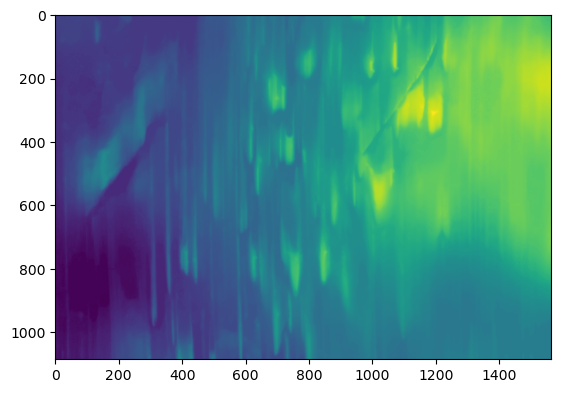

Opened topographic data file...


In [9]:

# Load the topographic data
with rasterio.open(Input_DEM) as main_ds:
    main_inarr = main_ds.read(1)  # Read the first band of the raster
    profile = main_ds.profile  # Save metadata for output files

plt.figure()
plt.imshow(main_inarr)
plt.show()

print("Opened topographic data file...")


### Opening NDWI file

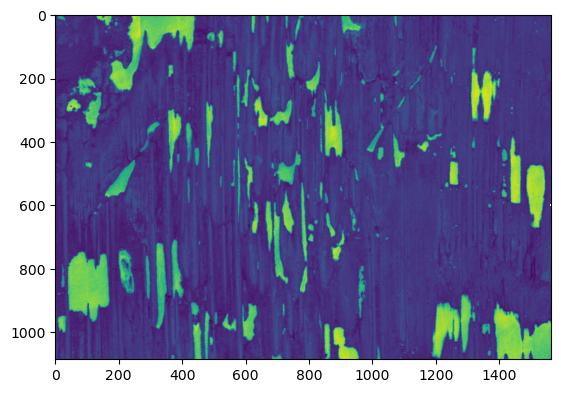

Opened NDWI data file...


In [10]:

# Load the topographic data
with rasterio.open(Input_NDWI) as NDWI_ds:
    NDWI_inarr = NDWI_ds.read(1)  # Read the first band of the raster

plt.figure()
plt.imshow(NDWI_inarr)
plt.show()

print("Opened NDWI data file...")


### Computing Volumetric Obscurance (VO)

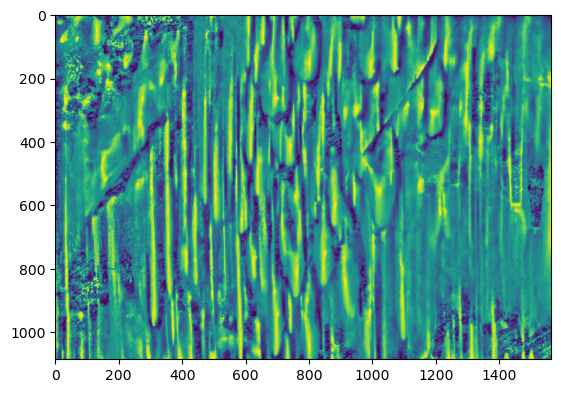

Computed Volumetric Obscurance (VO)...


In [11]:
vo_image = calculate_vo(main_inarr, radius, exaggeration)  # Calculate VO using input parameters
plt.figure()
plt.imshow(vo_image)
plt.show()

print("Computed Volumetric Obscurance (VO)...")


### Applying threshold to VO image

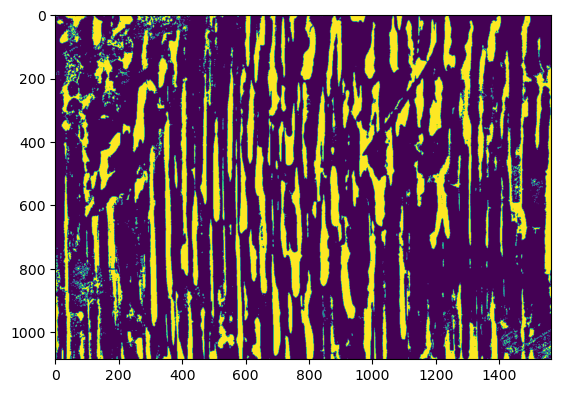

Applied threshold to VO image...


In [12]:
thresholded_image = threshold_vo(vo_image, vo_threshold)  # Threshold the VO image
plt.figure()
plt.imshow(thresholded_image)
plt.show()

print("Applied threshold to VO image...")


### Filling holes in the thresholded image

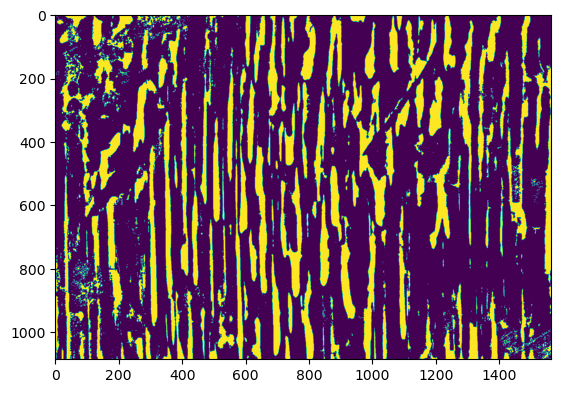

Filled holes in the thresholded image...


In [13]:
filled_image = fill_bedform_holes(thresholded_image)  # Fill holes in the image

plt.figure()
plt.imshow(filled_image)
plt.show()

print("Filled holes in the thresholded image...")


### NDWI masking 

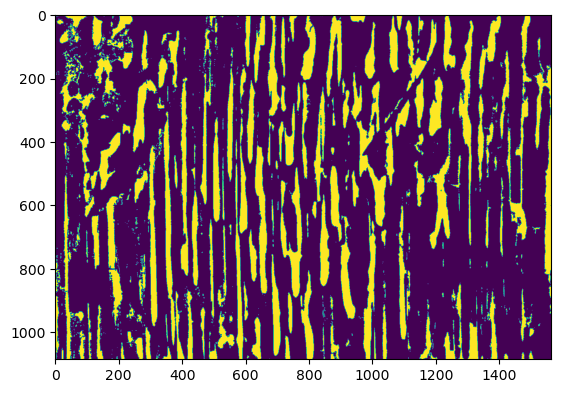

Masked image where NDWI is below 0...


In [17]:
# Create a mask where NDWI is below 0
mask = NDWI_inarr < 0
masked_image = filled_image * mask  # Apply the mask to the thresholded image
plt.figure()
plt.imshow(masked_image)
plt.show()

print("Masked image where NDWI is below 0...")


### Extracting polygons from filled image

In [18]:
# Extract polygons from the filled image
polygons = extract_polygons(masked_image, profile['transform'])

print("Extracted polygons from filled image...")


Extracted polygons from filled image...


### Smoothing polygons and exporting smoothed polygons

Smoothed polygons...
Saving smoothed polygons to GeoPackage...
Saved smoothed polygons to GeoPackage...


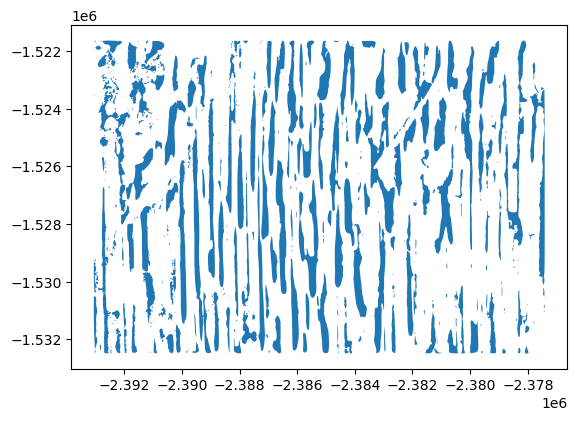

In [19]:

# Convert the list of polygons to a GeoDataFrame
polygons_gdf = gpd.GeoDataFrame(geometry=polygons, crs=profile['crs'])

# Smooth the polygons
bedforms = smooth_geodataframe(polygons_gdf, alpha, beta, iterations)
print("Smoothed polygons...")

bedforms.plot()

print("Saving smoothed polygons to GeoPackage...")
bedforms.to_file(Output_outlines, driver="GPKG")
print("Saved smoothed polygons to GeoPackage...")

### Skeletonization and  centerlines production


In [21]:

skeleton_image = skeletonize(masked_image)  # Perform skeletonization


G = skeleton_to_graph(skeleton_image)  # Convert skeleton to a graph


longest_paths = find_longest_paths(G)  # Find the longest paths in the graph


paths_image = create_longest_paths_image(skeleton_image, longest_paths)  # Visualize longest paths


geo_paths = convert_to_geographical_coords(longest_paths, main_ds.transform)  # Convert paths to geographic coordinates

print("Extracted centerlines from filled image...")



line_geometries = [LineString(path) for path in geo_paths if len(path) > 1]
gdf = gpd.GeoDataFrame(geometry=line_geometries, crs=profile['crs'])



Extracted centerlines from filled image...


### Smoothing centerlines and exporting smoothed centerlines

Smoothed centerlines...
Saved smoothed centerlines to GeoPackage...


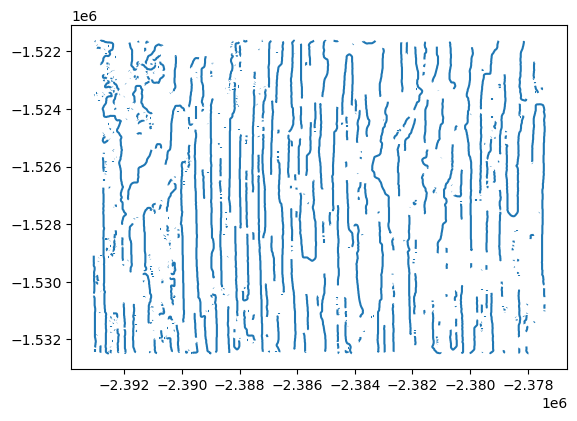

In [22]:
# Centerlines smoothing 

centerlines = smooth_centerlines(gdf, alpha, beta, iterations)
print('Smoothed centerlines...')

centerlines.plot()

centerlines.to_file(Output_centerlines, driver="GPKG")
print("Saved smoothed centerlines to GeoPackage...")
